# Treatment T11

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn


TREATMENT = "t11"

export_folder = f"../data/output/diagrams/{TREATMENT}"
os.makedirs(export_folder, exist_ok=True)

# Read and sanitize the data
df = pd.read_csv(f"../data/{TREATMENT}/export/result__{TREATMENT}_prop.csv")
df_full = df.copy()
# drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code"]
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code", "prop_time_spent"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df_full[["offer", "offer_final", "min_offer"]].describe()

,offer,offer_final,min_offer
count,102.000000,102.000000,102.000000
mean,44.558824,46.470588,40.490196
std,19.180009,17.371711,20.264462
min,5.000000,0.000000,0.000000
25%,40.000000,40.000000,30.000000
50%,50.000000,50.000000,45.000000
75%,50.000000,50.000000,50.000000
max,100.000000,100.000000,100.000000


**Correlation to the target value**

In [3]:
import seaborn as sns
from core.utils.preprocessing import df_to_xydf, df_to_xy
# Correlation Matrix Heatmap
CORRELATION_THRESHOLD = 0.20


corr_min_offer = df.corr()["min_offer"]
corr_columns = corr_min_offer[abs(corr_min_offer)>=CORRELATION_THRESHOLD].keys()
select_columns = [col for col in corr_columns if col != "min_offer"]

df_x, df_y = df_to_xydf(df=df, select_columns=select_columns)
df_corr = df_x.copy()
df_corr['min_offer'] = df_y['min_offer']

corr = df_corr.corr()

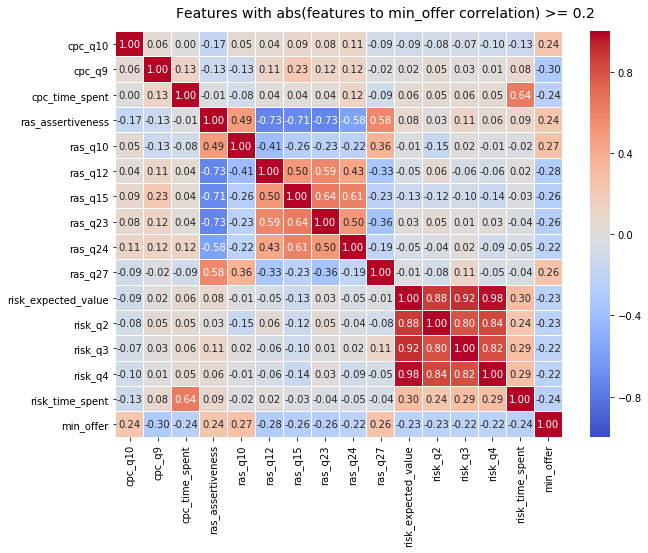

In [4]:
f, ax = plt.subplots(figsize=(10, 7))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05, vmax=1, vmin=-1)
f.subplots_adjust(top=0.93)
t= f.suptitle(f'Features with abs(features to min_offer correlation) >= {CORRELATION_THRESHOLD}', fontsize=14)

**Responder's min_offer / Proposer's over and final_offer distribution**

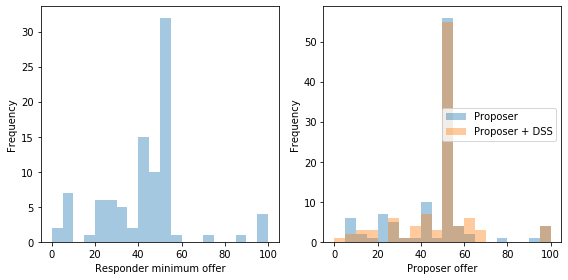

In [5]:

bins = list(range(0, 105, 5))
f, axes = plt.subplots(1, 2, figsize=(8,4))
ax = sns.distplot(df["min_offer"], hist=True, kde=False, axlabel="Responder minimum offer", bins=bins, ax=axes[0])
_ = ax.set_ylabel("Frequency")

ax = sns.distplot(df_full["offer"], hist=True, kde=False, axlabel="Proposer offer", bins=bins, label="Proposer", ax=axes[1])
_ = ax.set_ylabel("Frequency")
ax = sns.distplot(df_full["offer_final"], hist=True, kde=False, axlabel="Proposer offer", bins=bins, label="Proposer + DSS", ax=axes[1])
_ = ax.set_ylabel("Frequency")

plt.legend(loc='center right')
plt.tight_layout()

ax.figure.savefig(os.path.join(export_folder, "min_offer_offer.pdf"))

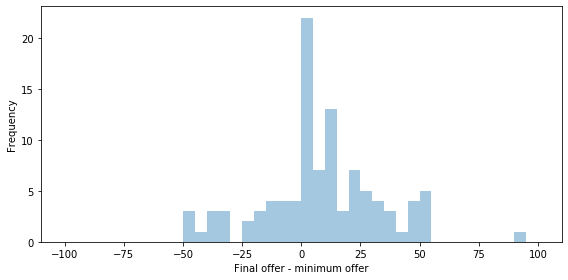

In [6]:
bins = list(range(-100, 105, 5))

plt.figure(figsize=(8,4))
offer_min_offer_diff = df_full["offer_final"] - df_full["min_offer"]
ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="Final offer - minimum offer", bins=bins)
_ = ax.set_ylabel("Frequency")
plt.tight_layout()
ax.figure.savefig(os.path.join(export_folder, "offer_final-min_offer.pdf"))

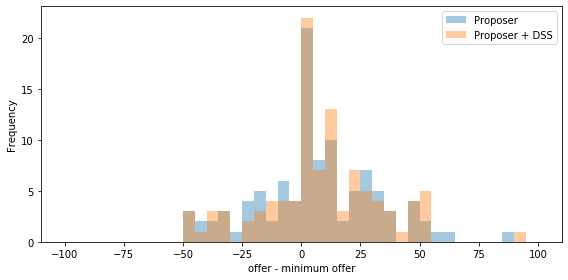

In [7]:
bins = list(range(-100, 105, 5))

plt.figure(figsize=(8,4))
offer_min_offer_diff = df_full["offer"] - df_full["min_offer"]
ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="offer - minimum offer", bins=bins, label="Proposer")
_ = ax.set_ylabel("Frequency")


offer_min_offer_diff = df_full["offer_final"] - df_full["min_offer"]
ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="offer - minimum offer", bins=bins, label="Proposer + DSS", ax=ax)
plt.legend()
plt.tight_layout()
ax.figure.savefig(os.path.join(export_folder, "offer-min_offer.pdf"))

In [8]:
from core.models.metrics import cross_compute, avg_gain_ratio, gain_mean, rejection_ratio, loss_sum, MAX_GAIN

def get_infos(min_offer, offer, metrics=None, do_cross_compute=False):
    if metrics is None:
        metrics = [avg_gain_ratio, gain_mean, rejection_ratio, loss_sum]
    #df = pd.DataFrame()
    infos = dict()
    for idx, metric in enumerate(metrics):
        if do_cross_compute:
            infos[metric.__name__] = cross_compute(min_offer, offer, metric)
        else:
            infos[metric.__name__] = metric(min_offer, offer)

    return infos

**Proposer's performance**

In [9]:
df_infos = pd.DataFrame()
#Human (fixed-matching) performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer']), ignore_index=True)
#Human (cross-matched) average performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer'], do_cross_compute=True), ignore_index=True)
#Human + DSS (fixed-matching) performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final']), ignore_index=True)
#Human + DSS(cross-matched) average performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final'], do_cross_compute=True), ignore_index=True)
#Top-model (fixed 50% prediction) average performance t00
fixed_offer = MAX_GAIN // 2
df_infos = df_infos.append(get_infos(df_full['min_offer'], [fixed_offer], do_cross_compute=True), ignore_index=True)

df_infos.index = ["Proposer", "Proposer (cross matched)", "Proposer + DSS", "Proposer + DSS (cross matched)", "AI-System"]

df_infos = df_infos.loc[["Proposer", "Proposer + DSS", "AI-System"]]
df_infos


,avg_gain_ratio,gain_mean,loss_sum,rejection_ratio
Proposer,0.520278,32.990196,2705.0,0.313725
Proposer + DSS,0.559847,34.558824,2545.0,0.264706
AI-System,0.755548,45.588235,1420.0,0.088235


In [10]:
def woa(offer_final, offer, ai_offer):
    res = (abs(offer_final - offer) ) / (abs(ai_offer - offer ))
    res = res[np.invert(np.isnan(res) | np.isinf(res))]
    res = np.clip(res, 0, 1)
    return abs(res).mean()
    
def get_rel_gain(df_infos):
    acc = df_infos['avg_gain_ratio']['Proposer']
    acc_dss = df_infos['avg_gain_ratio']['Proposer + DSS']
    return 100 * abs(acc - acc_dss) / acc

def get_dss_usage(df_full):
    return 100 * (df_full.ai_nb_calls > 0).mean()

print("rel_gain: ", round(get_rel_gain(df_infos), 2), "%")
print("dss_usage: ", round(get_dss_usage(df_full), 2), "%")    
print("woa: ", woa(df_full['offer_final'], df_full['offer'], df_full['ai_offer']))

rel_gain:  7.61 %
dss_usage:  91.18 %
woa:  0.4251121463077985
